# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

1. Metro link: [https://wdl-data.fra1.digitaloceanspaces.com/medellin/medellin_metro_stations_and_routes.zip](here)
2. Bike load csv: [https://wdl-data.fra1.digitaloceanspaces.com/medellin/bike_loans.zip](here)
3. Bus routes:[https://wdl-data.fra1.digitaloceanspaces.com/medellin/medellin_bus_routes.zip](here)

## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

## Development
Start coding here! 👩‍💻

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

### importing 

In [73]:
import pandas as pd 
import numpy as np
import geopandas as gpd
import fiona
import os
import zipfile
from folium import Map, CircleMarker, Vega, Popup, Marker, PolyLine, Icon, Choropleth, LayerControl
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
import shapely
import matplotlib
from ipywidgets import interact
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa 
from collections import Counter
import re
from datetime import datetime

We are now dealing with different types of extensions.  <br> 
The file we are using are composed with many rows and for this reason is easier to call them just when we need it.  
For this reason we are going to create a class that will be able to read and extract the data, already operating the first cleaning steps. 

### Extracting

In [2]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
class Databases:
    def __init__(self, csv, anva, smm, metro):
        self.csv = csv
        self.anva = anva 
        self.smm = smm
        self.metro = metro

    def extract_csv(self):
        file = pd.read_csv(f'data/bike_loans/{self.csv}', sep=';').drop(columns=['Importe', 
                                                                        'DescripcionImporte', 
                                                                        'operario'])
        file['Fecha_Prestamo'] = pd.to_datetime(file['Fecha_Prestamo'])
        file['Fecha_Devolucion'] = pd.to_datetime(file['Fecha_Devolucion'])
        return file
        
    
    def extract_anva(self):
        bus_routes_AMVA = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.anva}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                bus_routes_AMVA = gpd.GeoDataFrame(pd.concat([bus_routes_AMVA, df], ignore_index=True))
        return bus_routes_AMVA
    
    def extract_smm(self):
        smm_bus_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.smm}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                smm_bus_routes = gpd.GeoDataFrame(pd.concat([smm_bus_routes, df], ignore_index=True))
        return smm_bus_routes
    
    def extract_metro(self):
        metro_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/medellin_metro/{self.metro}'):
            for file in files:
                path = os.path.join(root, file)
                print(path)
                if path.endswith('.kmz'):
                    kmz = zipfile.ZipFile(path, 'r')
                    kml = kmz.open('doc.kml', 'r')
                    df = gpd.read_file(kml, driver='KML')
                    metro_routes = gpd.GeoDataFrame(pd.concat([metro_routes, df], ignore_index=True))
        return metro_routes

In [3]:
databases = Databases('bike_loans.csv','Kml Ruta AMVA','kml Ruta SMM','medellin_metro_stations')

In [4]:
bikes = databases.extract_csv()

### Prime Analysis

We can start our analysis with general description of the dataset. <br>
**NB**: In our dataset we are dealing with all categorical features or timeseries: there is no need to run ```describe()``` 

- Id_Tag_Bicicleta : column regarding unique id of each bicycle 
***let's have a look on how many times the same bike is used (how many times the unique id is present in the df)**

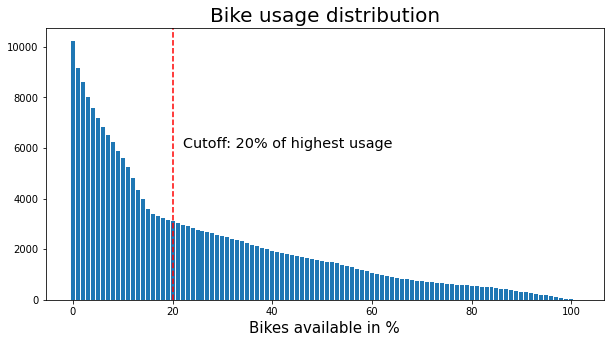

In [5]:
plt.figure(figsize=(10,5))
plt.title('Bike usage distribution', size=20)
counts = bikes.Id_Tag_Bicicleta.value_counts()[::66]
y_pos = np.arange(len(counts))
plt.bar(y_pos, counts)
plt.xlabel('Bikes available in %', size=15)
plt.text(x=22, y=6000, s=f'Cutoff: 20% of highest usage', size='x-large')
plt.axvline(20, color='r', linestyle='--')

plt.show()

In [6]:
print(f'In total we have {len(bikes.Id_Tag_Bicicleta.unique())} unique bikes over all recorded time')

In total we have 6698 unique bikes over all recorded time


As we can see there is a clear cutoff in the 20% of the distribution. That's can also aimed to the different time of putting that bike on the streets.

In our dataset we have information about the bike itself, the station of arrival and departures and the costumer. To characterized all this information we have also 2 time series: ```Fecha_Prestamo``` & ```Fecha_Devolucion``` 

<br>
Thank to these we can have an idea of the time in which the bike are more used, which routes are more popular during a certain range of time and also how the data collected has changed during the years, according maybe to the change in habits of the population. 

In [7]:
# Extracting just the hour: 
bikes['hour_init']= bikes['Fecha_Prestamo'].dt.hour
bikes['hour_end']=bikes['Fecha_Devolucion'].dt.hour
bikes.head(5)

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist,hour_init,hour_end
0,6501462,18701,000017B00743,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,929.0,14,14
1,6501318,41811,000017AFF83C,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,1612.0,14,14
2,6501489,96620,000017AFFB6F,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,1679.0,14,14
3,6501001,16055,0000182A3B7B,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,1076.0,13,14
4,6501421,6431,000017AFE810,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,1176.0,14,14


The highest usage of bikes is at 17 and 7


/Users/olgacravesana/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


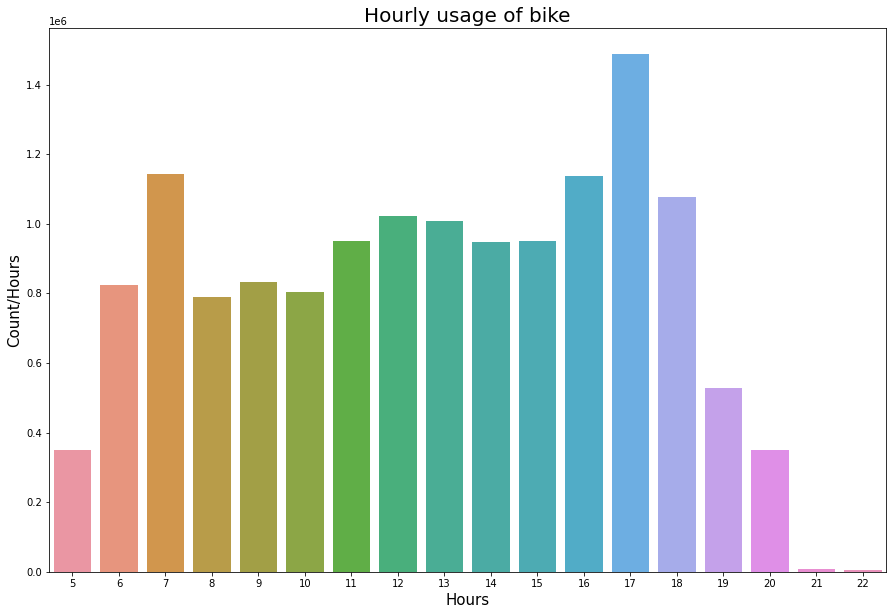

In [8]:
plt.figure(figsize=(15,10))
hours = pd.DataFrame(bikes.hour_init.value_counts())
hours=hours.drop(index=[1,2,3,4,23,0]) #inactivity hours
sns.barplot(hours.index,hours.hour_init)
plt.title('Hourly usage of bike', size=20)
plt.xlabel('Hours', size=15)
plt.ylabel('Count/Hours', size=15)
print(f'The highest usage of bikes is at 17 and 7')

In [9]:
bikes= bikes.dropna()

In [10]:
bikes['routes'] = bikes.apply(lambda x: f'{x.Id_Aparcamiento_Origen}_{int(x.Id_Aparcamiento_Destino)}', axis=1)

- We can now try to understand the routes depending on the our of the day.
- During all the analysis we will focus on the hours as main indicator as our target regard the best distribution of bikes **xhour**

In [11]:
# grouping by hour
agg = {'Id_Aparcamiento_Origen':'count', 
      'routes': lambda x: list(x)}
routes_by_hr = bikes.groupby('hour_init').agg(agg).rename(columns={'Id_Aparcamiento_Origen':'count_rentals'})

Now we can see the rental distribuition over the day thank to the ```count``` column in our new df 

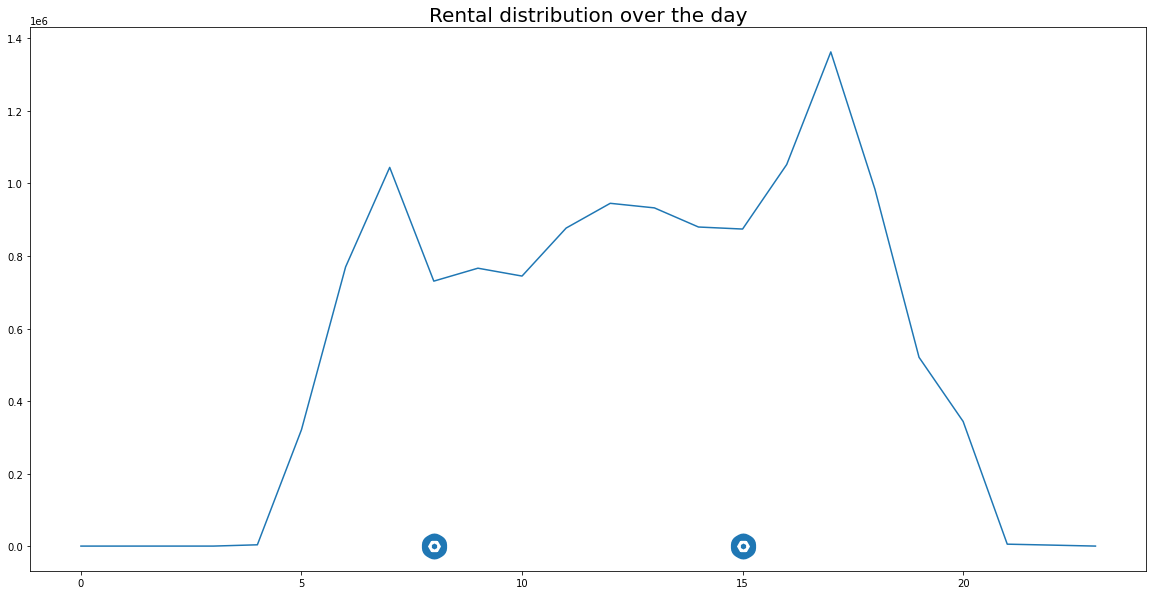

In [12]:
plt.figure(figsize=(20,10))
plt.plot(routes_by_hr.count_rentals)
plt.title('Rental distribution over the day', size=20)
plt.scatter([8,15], [1,1], marker='h', linewidths=20)

In [13]:
# count the amount of occuring routes per hour (counting the ocurrences in the lists)
routes_dict = {}
for c, row in routes_by_hr.iterrows():
    routes_dict[c] = dict(Counter(row.routes))

routes_usage = pd.DataFrame.from_dict(routes_dict)

Now we can create different features that shows the movement of the bikes during the different hours.

In [14]:
routes_usage['start_id'] = routes_usage.index.map(lambda x: x.split('_')[0])
routes_usage['finish_id'] = routes_usage.index.map(lambda x: x.split('_')[1])
routes_usage['no_move'] = routes_usage.start_id == routes_usage.finish_id

What we can actually see right now? 
- how many times were bikes returned to the **same** station
- how many times were bikes rented **less** than 2 mins

We can now focus on the top **5 routes xhour**

In [15]:
rank_routes = {}
for hour in routes_usage.columns:
    top3 = dict(routes_usage[hour].sort_values(ascending=False)[:3])
    rank_routes[hour] = top3
rank_routes_df = pd.DataFrame(rank_routes).T

We observed that the counts from 0 to 4 in the morning are too low and for this we decide to split the df 

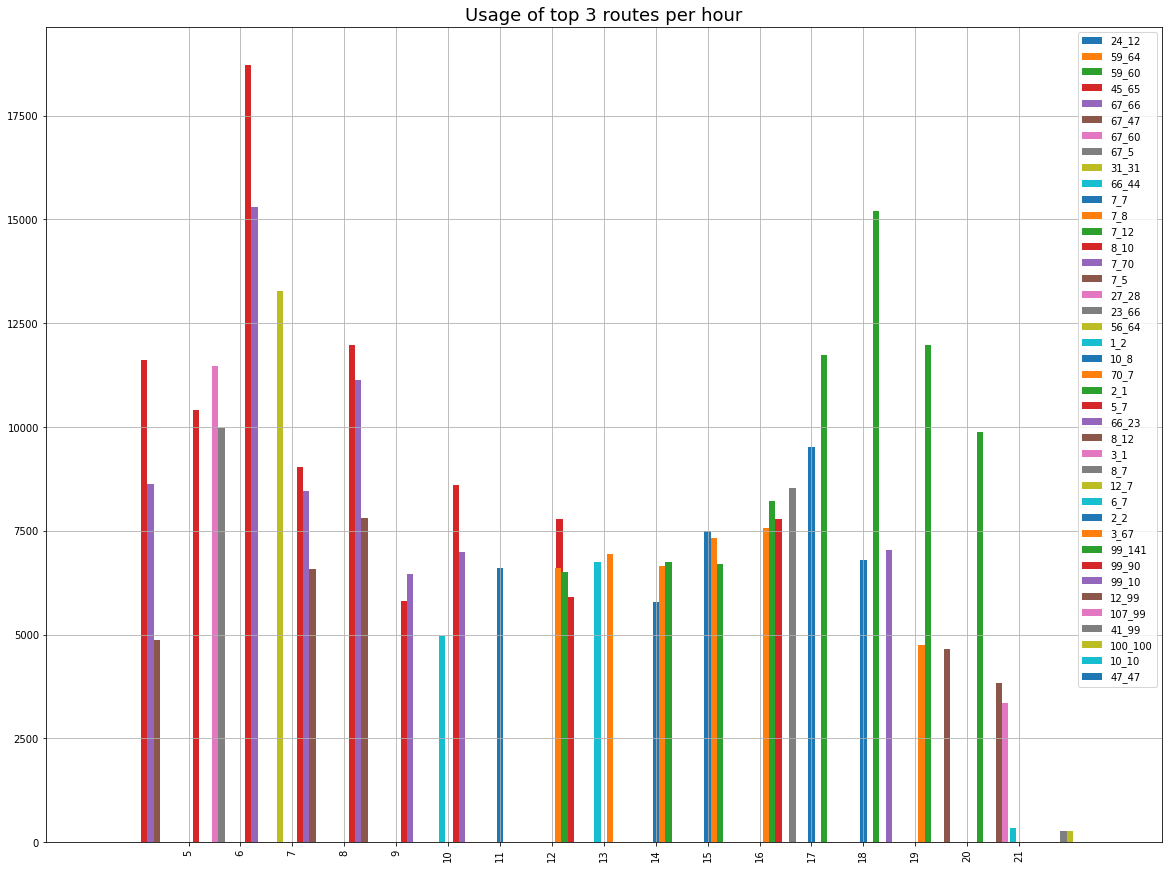

In [16]:
rank_routes_df.loc[5:21].plot(kind='bar', figsize=(20,15), width=5, stacked=False, align='center')
plt.title('Usage of top 3 routes per hour', size=18)
plt.grid()
plt.show()

**Note**<br>
- In the morning hours the route ```8_10``` is represented in high numbers followed by ```7_70```
- In the evening hours there are more ```2_1``` and ```10_8``` rentals recorded
- Noons and afternoons have a stable distribution of ```70_7``` (returns of the mornings)
- Way less people go back the same way they came from (```8_10``` vs. ```10_8```)

### Pandemic? 

In the last year our habits changed a lot due to the pandemic we are dealing day by day with. For this reason we cannot avoid to take it in account.

**Let's see how our data changed before and after the spreading of Corona Virus:**

In [17]:
bikes['year'] = bikes.Fecha_Prestamo.dt.year
evolution_bikes = {}
for year in sorted(bikes.year.unique())[::-1]:
    df_filter = bikes[bikes.year == year]
    df_filter_prev = bikes[bikes.year == year-1]
    bikes_ = df_filter.Id_Tag_Bicicleta.unique()
    bikes_prev = df_filter_prev.Id_Tag_Bicicleta.unique()
    count_up = len([bike for bike in bikes_ if bike not in bikes_prev])
    count_down = -len([bike for bike in bikes_prev if bike not in bikes_])
    evolution_bikes[year] = {'loss': count_down, 'win': count_up}

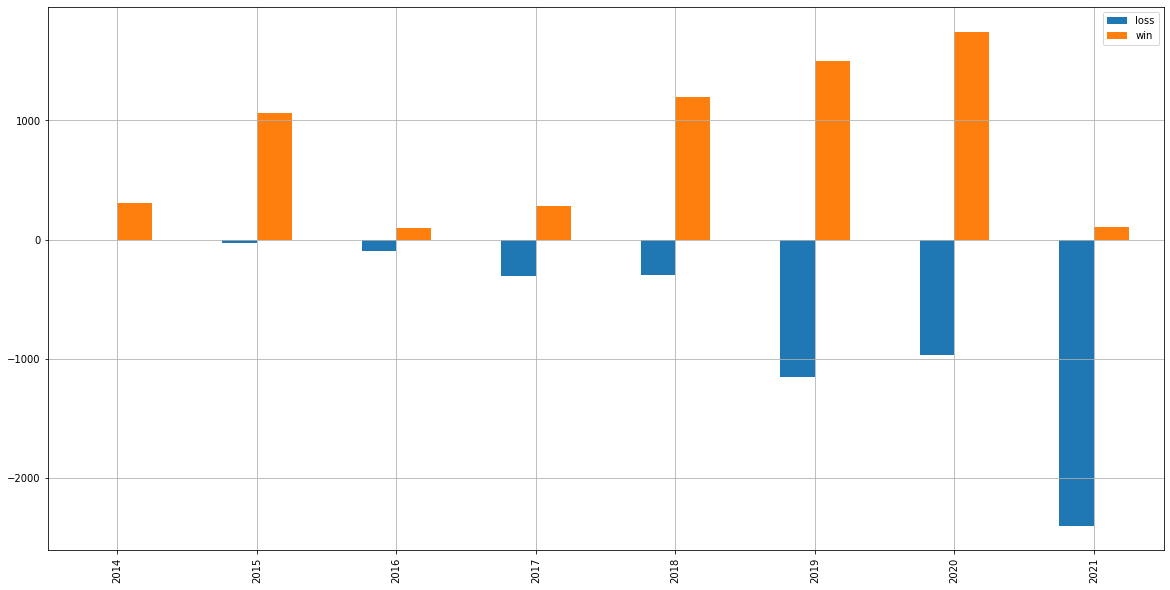

In [18]:
pd.DataFrame(evolution_bikes).T.sort_index().plot(kind='bar', figsize=(20,10))
plt.grid()

**Note**<br>
we can see that a lot of bikes stopped appearing in 2021. The highest investments have been made in 2020.

**What about changing in the routes?**

In [19]:
evolution_routes = {}
for year in sorted(bikes.year.unique())[::-1]:
    df_filter = bikes[bikes.year == year]
    df_filter_prev = bikes[bikes.year == year-1]
    routes_ = df_filter.routes.unique()
    routes_prev = df_filter_prev.routes.unique()
    count_up = len([route for route in routes_ if route not in routes_prev])
    count_down = -len([route for route in routes_prev if route not in routes_])
    evolution_routes[year] = {'loss': count_down, 'win': count_up}

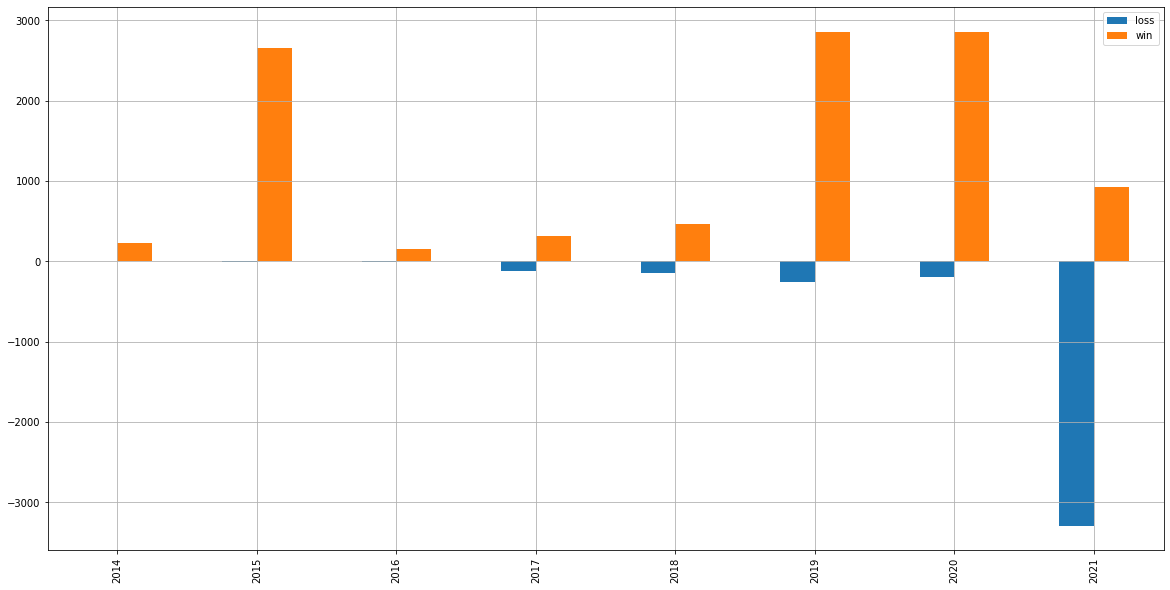

In [20]:
pd.DataFrame(evolution_routes).T.sort_index().plot(kind='bar', figsize=(20,10))
plt.grid()

**Note**<br>
In 2019 and 2020 a lot of new routes were explored by the bike users. As we predicted there were changing in the investment as well as in the usage of the bicycles. 

**Did the total of rentals changed during the years?**

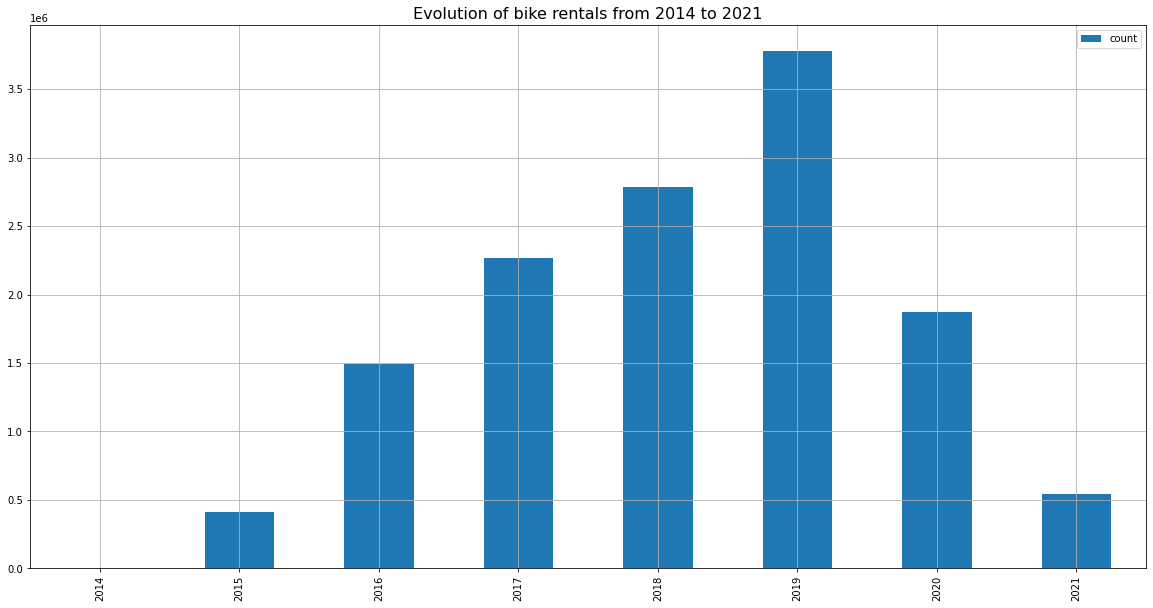

In [21]:
# calculate evolution of rentals
evolution_rentals = {}
for year in sorted(bikes.year.unique()):
    df_filter = bikes[bikes.year == year]
    count = df_filter.Id_Historico_Prestamo.count()
    evolution_rentals[year] = count
evolution_rentals_df = pd.DataFrame.from_dict(evolution_rentals, orient='index').rename(columns={0:'count'})
evolution_rentals_df.plot(kind='bar', figsize=(20,10))
plt.grid()
plt.title("Evolution of bike rentals from 2014 to 2021", size=16)
plt.show()

**As predicted we see a big decrease in rentals in 2020 and 2021.**
1. we cannot run a model without taking this real world event in account
2. we decide to split the data and work just on the pre-pandemic information to get a more informative and more reliable model 

**Split of dataframe**

In [22]:
bikes_nocov = bikes[bikes.Fecha_Devolucion <= '31/12/2019']

In [23]:
print(f'Even after have drop all the Nan values and have taken just rows referring to the prepandemic world,\nwe have a dataset with {bikes_nocov.shape[0]} rows.')

Even after have drop all the Nan values and have taken just rows referring to the prepandemic world,
we have a dataset with 10737486 rows.


### Model

In [45]:
#re-importing original df
bikes = databases.extract_csv()

Following some review, we decided to focus entirely on the data from **2019**. 

There are several reasons for this:

1. We believe that using data at the beginning of the project might be unrepresentative of how it is currently operated (just before COVID). 
2. For dimensionality purposes, the more rows and dates we turn into time series, the great amount of data to process.

**NOTE:** 
<br>
We are focusing solely on 2019, therefore we are removing the bikes that were loaned **AND** deposited back in 2019. Therefore, bikes dropped after 31/12/2019 wouldn't be counted.

In [46]:
# bikes_2019_loans_only = bikes_nocov[(bikes_nocov['Fecha_Prestamo'].dt.year == 2019)]
bikes_2019 = bikes[(bikes['Fecha_Prestamo'].dt.year == 2019) & (bikes['Fecha_Devolucion'].dt.year == 2019)]
bikes_2019

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9,1,43.0,1.0,1366.0
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44,15,44.0,15.0,976.0
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9,1,70.0,1.0,2699.0
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89,2,56.0,1.0,638.0
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12,1,22.0,NaN,558.0
...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40,1,50.0,1.0,541.0
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28,1,50.0,1.0,715.0
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113,1,28.0,1.0,3497.0
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39,15,41.0,15.0,534.0


##### Preprocessing: Nan Values

In [47]:
bikes_2019['Id_Aparcamiento_Origen'].isna().sum(), bikes_2019['Id_Aparcamiento_Destino'].isna().sum()

(0, 1009)

We are seeing above the amount of ```NaN``` values for the columns - station of origin and station of destination. What is happening is that there are no ```NaN``` values station of origins and **1009** for stations of **destination**. What we assume could have happened, is that someone stole the bikes (is once again some drunk people took their fucking bikes and threw them into the river or something along those lines), hence never reached their destination.

**Solution**: <br>
Filling those NaN values with -1 for conversion purposes, so that we can more easily use the ```.apply()``` function when creating new features

In [48]:
bikes_2019['Id_Aparcamiento_Destino'] = bikes_2019['Id_Aparcamiento_Destino'].fillna(np.NaN)
bikes_2019['Posicion_Destino'] = bikes_2019['Posicion_Destino'].fillna(np.NaN)

<ipython-input-48-c65db0f1f3d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Id_Aparcamiento_Destino'] = bikes_2019['Id_Aparcamiento_Destino'].fillna(np.NaN)
<ipython-input-48-c65db0f1f3d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Posicion_Destino'] = bikes_2019['Posicion_Destino'].fillna(np.NaN)


##### Columns type:
We can see from above that some similar columns are of different types such as ```Id_Aparcamiento_Destino``` = ```float64``` AND ```Id_Aparcamiento_Origen``` = ```int64```

 

In [49]:
bikes_2019.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Num_Bici_Hist                     float64
dtype: object

In [50]:
bikes_2019['Id_Aparcamiento_Origen'] = bikes_2019['Id_Aparcamiento_Origen'].astype(float)  
bikes_2019['Posicion_Origen'] = bikes_2019['Posicion_Origen'].astype(float)

<ipython-input-50-07e49c6f4f17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Id_Aparcamiento_Origen'] = bikes_2019['Id_Aparcamiento_Origen'].astype(float)
<ipython-input-50-07e49c6f4f17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Posicion_Origen'] = bikes_2019['Posicion_Origen'].astype(float)


##### Feature Creation: Supply & Demand

In [51]:
def create_supply_demand(x):
        if x >= 0:
            return 1
        elif x != x:
            return 0

What the function above does is to return 0 or 1 depending on whether each row has a station of origin or station of destination:
- Each time someone **loans** a new bike this is/can be represented as ```demand``` = 1. 
- Each time someone **drop** their bikes this can be represented as ```supply``` = 1. 

**Note**:
<br>
However, if the row does not have a station of destination i.e. the bike got lost/thrown in the river, then supply should be = **0**. For later use, this will be to find out if there is an ***imbalance*** of demand and supply for some stations.

In [52]:
bikes_2019['demand'] = bikes_2019['Id_Aparcamiento_Origen'].apply(create_supply_demand)
bikes_2019['supply'] = bikes_2019['Id_Aparcamiento_Destino'].apply(create_supply_demand)

<ipython-input-52-d43ed9cb3953>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['demand'] = bikes_2019['Id_Aparcamiento_Origen'].apply(create_supply_demand)
<ipython-input-52-d43ed9cb3953>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['supply'] = bikes_2019['Id_Aparcamiento_Destino'].apply(create_supply_demand)


In [53]:
# this should equal 1009 because there are 1009 NaN values
bikes_2019['supply'].isin([0]).sum()

1009

##### Creating new features - features to groupby:
We decided to create new features based on several columns that we wanted to merge together. <br>

Basically, our goal would be to **group by** ```station```, ```date``` and ```time```.

In [54]:
#station of loan + date and time (all in one column)
bikes_2019['loan_station_date_time'] = bikes_2019['Id_Aparcamiento_Origen'].astype('string') + " " +\
        bikes_2019['Fecha_Prestamo'].dt.date.astype('string') + " " +\
        bikes_2019['Fecha_Prestamo'].dt.hour.astype('string')
#station of drop off + date and time (all in one column)
bikes_2019['deposit_station_date_time'] = bikes_2019['Id_Aparcamiento_Destino'].astype('string') + " " +\
        bikes_2019['Fecha_Devolucion'].dt.date.astype('string') + " " + \
        bikes_2019['Fecha_Devolucion'].dt.hour.astype('string')

<ipython-input-54-c1b4dafe82f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['loan_station_date_time'] = bikes_2019['Id_Aparcamiento_Origen'].astype('string') + " " +\
<ipython-input-54-c1b4dafe82f6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['deposit_station_date_time'] = bikes_2019['Id_Aparcamiento_Destino'].astype('string') + " " +\


In [80]:
bikes_2019

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist,demand,supply,loan_station_date_time,deposit_station_date_time
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9.0,1.0,43.0,1.0,1366.0,1,1,9.0 2019-02-20 14,43.0 2019-02-20 14
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44.0,15.0,44.0,15.0,976.0,1,1,44.0 2019-08-22 9,44.0 2019-08-22 9
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9.0,1.0,70.0,1.0,2699.0,1,1,9.0 2019-08-22 9,70.0 2019-08-22 9
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89.0,2.0,56.0,1.0,638.0,1,1,89.0 2019-02-20 14,56.0 2019-02-20 14
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12.0,1.0,22.0,NaN,558.0,1,1,12.0 2019-01-02 12,22.0 2019-01-02 13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40.0,1.0,50.0,1.0,541.0,1,1,40.0 2019-12-31 13,50.0 2019-12-31 14
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28.0,1.0,50.0,1.0,715.0,1,1,28.0 2019-12-31 13,50.0 2019-12-31 14
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113.0,1.0,28.0,1.0,3497.0,1,1,113.0 2019-12-31 13,28.0 2019-12-31 14
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39.0,15.0,41.0,15.0,534.0,1,1,39.0 2019-12-31 13,41.0 2019-12-31 16


***GroupBy***:


1. Demand:

In [58]:
demand_per_station_per_hour = bikes_2019[['demand']].groupby(bikes_2019['loan_station_date_time']).sum()
demand_per_station_per_hour.reset_index(inplace=True)

#unstack informations: 
demand_per_station_per_hour[['station','date','time']] = \
                        demand_per_station_per_hour.loan_station_date_time.str.split(" ",expand=True)

demand_per_station_per_hour

,loan_station_date_time,demand,station,date,time
0,1.0 2019-01-02 10,5,1.0,2019-01-02,10
1,1.0 2019-01-02 11,8,1.0,2019-01-02,11
2,1.0 2019-01-02 12,17,1.0,2019-01-02,12
3,1.0 2019-01-02 13,7,1.0,2019-01-02,13
4,1.0 2019-01-02 14,12,1.0,2019-01-02,14
...,...,...,...,...,...
280484,99.0 2019-12-31 11,8,99.0,2019-12-31,11
280485,99.0 2019-12-31 12,13,99.0,2019-12-31,12
280486,99.0 2019-12-31 13,6,99.0,2019-12-31,13
280487,99.0 2019-12-31 8,1,99.0,2019-12-31,8


In [61]:
supply_per_station_per_hour = bikes_2019[['supply']].groupby(bikes_2019['deposit_station_date_time']).sum()
supply_per_station_per_hour.reset_index(inplace=True)

#unstack informations:
supply_per_station_per_hour[['station','date','time']] = \
supply_per_station_per_hour.deposit_station_date_time.str.split(" ",expand=True)

supply_per_station_per_hour

,deposit_station_date_time,supply,station,date,time
0,1.0 2019-01-02 10,4,1.0,2019-01-02,10
1,1.0 2019-01-02 11,8,1.0,2019-01-02,11
2,1.0 2019-01-02 12,12,1.0,2019-01-02,12
3,1.0 2019-01-02 13,7,1.0,2019-01-02,13
4,1.0 2019-01-02 14,8,1.0,2019-01-02,14
...,...,...,...,...,...
298700,99.0 2019-12-31 5,1,99.0,2019-12-31,5
298701,99.0 2019-12-31 6,1,99.0,2019-12-31,6
298702,99.0 2019-12-31 7,1,99.0,2019-12-31,7
298703,99.0 2019-12-31 8,5,99.0,2019-12-31,8


##### Cleaning:
We want to be sure to work with cleaned df:
- changing type of columns
- avoiding additional spaces
- create and use a date-time object
- drop the columns we don't need anymore


In [62]:
def clean_df(df, cols, index):
    df[cols] =  df[cols].astype(float) # string to float
    df.iloc[:,index]=  df.iloc[:,index].str.strip() #left strip
    return df

In [63]:
df1_clean = clean_df(demand_per_station_per_hour,['station','time'], 0)
df2_clean = clean_df(supply_per_station_per_hour,['station','time'], 0)

In [67]:
#searching for all the string containint '2019.' in column with station (loan or deposit) + date&time
pattern = re.compile(r'2019.*') 
def year_month_day_hour(x):
    return pattern.search(x).group()

df1_clean['year_month_day_hour'] = df1_clean['loan_station_date_time'].apply(year_month_day_hour)
df2_clean['year_month_day_hour'] = df2_clean['deposit_station_date_time'].apply(year_month_day_hour)

In [74]:
#changing type of column from string in date-time:
def convert_to_date(x):
    return datetime.strptime(x, '%Y-%m-%d %H')
df1_clean['year_month_day_hour'] = df1_clean['year_month_day_hour'].apply(convert_to_date)
df2_clean['year_month_day_hour'] = df2_clean['year_month_day_hour'].apply(convert_to_date)

In [76]:
#Dropping column containing station (loan or deposit) + date&time:
def drop_col(df):
    return df.iloc[:,1:]
df1_clean_drop = drop_col(df1_clean)
df2_clean_drop = drop_col(df2_clean)

In [78]:
df1_clean_drop

,demand,station,date,time,year_month_day_hour
0,5,1.0,2019-01-02,10.0,2019-01-02 10:00:00
1,8,1.0,2019-01-02,11.0,2019-01-02 11:00:00
2,17,1.0,2019-01-02,12.0,2019-01-02 12:00:00
3,7,1.0,2019-01-02,13.0,2019-01-02 13:00:00
4,12,1.0,2019-01-02,14.0,2019-01-02 14:00:00
...,...,...,...,...,...
280484,8,99.0,2019-12-31,11.0,2019-12-31 11:00:00
280485,13,99.0,2019-12-31,12.0,2019-12-31 12:00:00
280486,6,99.0,2019-12-31,13.0,2019-12-31 13:00:00
280487,1,99.0,2019-12-31,8.0,2019-12-31 08:00:00


In [79]:
df2_clean_drop 

,supply,station,date,time,year_month_day_hour
0,4,1.0,2019-01-02,10.0,2019-01-02 10:00:00
1,8,1.0,2019-01-02,11.0,2019-01-02 11:00:00
2,12,1.0,2019-01-02,12.0,2019-01-02 12:00:00
3,7,1.0,2019-01-02,13.0,2019-01-02 13:00:00
4,8,1.0,2019-01-02,14.0,2019-01-02 14:00:00
...,...,...,...,...,...
298700,1,99.0,2019-12-31,5.0,2019-12-31 05:00:00
298701,1,99.0,2019-12-31,6.0,2019-12-31 06:00:00
298702,1,99.0,2019-12-31,7.0,2019-12-31 07:00:00
298703,5,99.0,2019-12-31,8.0,2019-12-31 08:00:00


##### Merging dfs:

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀